<a href="https://colab.research.google.com/drive/1KSksZPsW6rNQfGW69wS8j5ietj3ayUkC" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes :
- This notebook takes around 6 minutes to run.
- I underlined the differences between the exam in the following code like this: <font color="red">**CHANGE**</font>.

# 0 - Introduction

This section introduces the dataset loading process, utilizing the requests library to download the necessary data from the GitHub repository.

In [282]:
import requests
import zipfile
import pickle as pk

url = "https://frasca.di.unimi.it/MLDNN/input_data.zip"

response = requests.get(url)
with open("data.zip", "wb") as f:
    f.write(response.content)

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
     zip_ref.extractall("unzipped_data")

with open("unzipped_data/input_data.pkl", "rb") as f:
     df = pk.load(f)


In [283]:
%pip install tensorflow

import warnings
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
import itertools
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix

from keras.regularizers import l1, l2
from keras.layers import (
    Input, Dense, BatchNormalization, Dropout, Embedding,
    Bidirectional, LSTM, Concatenate, Flatten
)
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

scaler = MinMaxScaler()


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


I suppress warnings to keep the output clean; mainly related to known deprecations in libraries that do not impact the result.

sanity check, everything is working fine 

In [284]:
df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Search Queries
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,3/27/2016 0:53,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,3/13/2016 20:35,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,1/10/2016 2:31,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,6/3/2016 3:36,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
993,64.20,27,66200.96,227.63,Phased zero tolerance extranet,Edwardsmouth,1,Isle of Man,2/11/2016 23:45,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2/11/2016 21:49,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,4/22/2016 2:07,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,3/24/2016 2:35,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


To adhere to the practical time constraints of this evaluation, I have implemented a two-fold strategy to manage the overall computational cost while maintaining the methodological integrity of the project. This involves a trade-off between the volume of data processed and the breadth of hyperparameter exploration.

In [285]:
df_full = df.copy()
sample_fraction = 0.50
target_column = 'Clicked on Ad'
reduced_df, _ = train_test_split(
    df_full,
    train_size=sample_fraction,
    stratify=df_full[target_column],
    random_state=42
)

reduced_df = df_full



---



# 2 - Input

This section in the exam was divided in two subparts:
* How to (if) preprocess input data and which data would you retain/use;
* Which is the input of the model, and how is it represented;

to avoid any kind of data leakage, I first divide into train, validation, and test

In [286]:
train_df, temp_df = train_test_split(
    reduced_df, test_size=0.20, random_state=42, shuffle=True
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, shuffle=True
)
print(len(train_df), len(val_df), len(test_df))

762 95 96


## 2.1 preprocessing:

### 2.1.1 - Search Queries
 

come ho detto durante l'esame questi vetori onehot encodati non hanno bisogno di ulteriore preprocessing

In [287]:
# Convert 'Search Queries' column (list of 0/1) into a numpy array for each split
def extract_search_queries(df):
    # Assumes each entry is a list of 0/1
    return np.stack(df['Search Queries'].values)

train_hot_tensor = extract_search_queries(train_df)
val_hot_tensor = extract_search_queries(val_df)
test_hot_tensor = extract_search_queries(test_df)

### 2.1.3 - Timestamp 

As stated in the exam, I am going to:

1. convert: minute, hour, day, month using a cyclic sine/cosine function
2. convert the year into distance from the first istance


In [288]:
def transform_dates(df, min_year=None):
    # Parse the timestamp with both date and time
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %H:%M')
    # Extract components
    df['Review_Day'] = df['Timestamp'].dt.day
    df['Review_Month'] = df['Timestamp'].dt.month
    df['Review_Hour'] = df['Timestamp'].dt.hour
    df['Review_Minute'] = df['Timestamp'].dt.minute
    df['Review_Year'] = df['Timestamp'].dt.year

    # Cyclic encoding for day, month, hour, minute
    df['Review_Day_sin'] = np.sin(2 * np.pi * df['Review_Day'] / 31)
    df['Review_Day_cos'] = np.cos(2 * np.pi * df['Review_Day'] / 31)
    df['Review_Month_sin'] = np.sin(2 * np.pi * df['Review_Month'] / 12)
    df['Review_Month_cos'] = np.cos(2 * np.pi * df['Review_Month'] / 12)
    df['Review_Hour_sin'] = np.sin(2 * np.pi * df['Review_Hour'] / 24)
    df['Review_Hour_cos'] = np.cos(2 * np.pi * df['Review_Hour'] / 24)
    df['Review_Minute_sin'] = np.sin(2 * np.pi * df['Review_Minute'] / 60)
    df['Review_Minute_cos'] = np.cos(2 * np.pi * df['Review_Minute'] / 60)
    if min_year is None:
        min_year = df['Review_Year'].min()
    df['Review_Year_Since'] = df['Review_Year'] - min_year
    df.drop(columns=['Timestamp', 'Review_Day', 'Review_Month', 'Review_Hour', 'Review_Minute', 'Review_Year'], inplace=True)
    return df, min_year

train_df, min_year = transform_dates(train_df)
val_df, _ = transform_dates(val_df, min_year)
test_df, _ = transform_dates(test_df, min_year)

### 2.1.4 Ad Topic Line

I clean the ad text by removing punctuation, stop words, and non-ASCII characters, and converting everything to lowercase

In [289]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def preprocess_ad(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')    
    text = text.replace('--', ' ')    
    words = text.split()    
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]    
    words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To better understand the input data, I analyze the distribution of the number of words in each review after preprocessing. I compute basic statistics and plot a histogram to visualize how review lengths are spread.

In [290]:
for df_ in [train_df, val_df, test_df]:
    df_["clean_text"] = df_["Ad Topic Line"].apply(preprocess_ad)
    df_["ad_length"] = df_["clean_text"].apply(lambda x: len(x.split()))
    df_["tokens"] = df_["clean_text"].str.split()

count    762.000000
mean       3.169291
std        0.553523
min        2.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        6.000000
Name: ad_length, dtype: float64


Quantile 50%: Reviews have length <= 3 words.
Quantile 75%: Reviews have length <= 3 words.
Quantile 90%: Reviews have length <= 4 words.
Quantile 95%: Reviews have length <= 4 words.
Quantile 98%: Reviews have length <= 5 words.
Quantile 99%: Reviews have length <= 5 words.
Quantile 100%: Reviews have length <= 6 words.


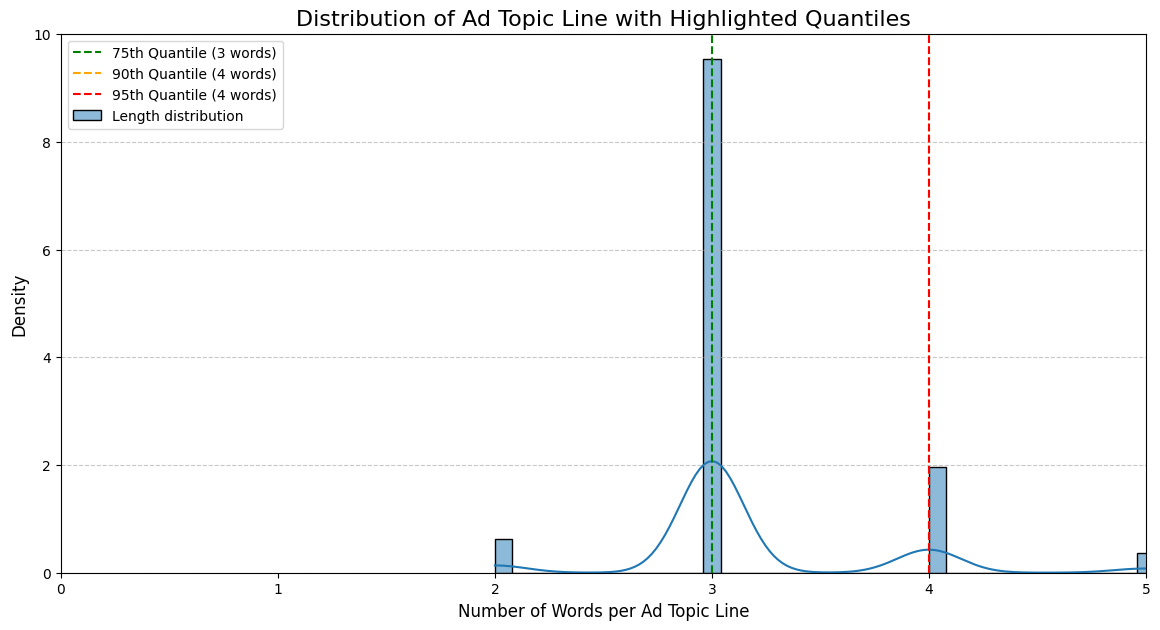

In [291]:
ad_length_stats = train_df["ad_length"].describe()
print(ad_length_stats)
print("\n")
quantiles = [0.50, 0.75, 0.90, 0.95, 0.98, 0.99, 1.00]
for q in quantiles:
    length_at_quantile = train_df["ad_length"].quantile(q)
    print(f"Quantile {q*100:.0f}%: Reviews have length <= {length_at_quantile:.0f} words.")

plt.figure(figsize=(14, 7))
sns.histplot(data=train_df, x="ad_length", bins=50, kde=True,
             label="Length distribution", stat="density")
plt.axvline(train_df["ad_length"].quantile(0.75), color='green', linestyle='--',
            label=f'75th Quantile ({train_df["ad_length"].quantile(0.75):.0f} words)')
plt.axvline(train_df["ad_length"].quantile(0.90), color='orange', linestyle='--',
            label=f'90th Quantile ({train_df["ad_length"].quantile(0.90):.0f} words)')
plt.axvline(train_df["ad_length"].quantile(0.95), color='red', linestyle='--',
            label=f'95th Quantile ({train_df["ad_length"].quantile(0.95):.0f} words)')
plt.title('Distribution of Ad Topic Line with Highlighted Quantiles', fontsize=16)
plt.xlabel('Number of Words per Ad Topic Line', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(0, train_df["ad_length"].quantile(0.99))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Based on the text preprocessing, a detailed analysis of the ad topic line lengths was conducted. The distribution and highlighted quantiles reveal several key insights:

*   The ad topic lines are predominantly very short and concise, with the most frequent length being **3 words**, as shown by the highest peak in the distribution.
*   The distribution is highly concentrated in a narrow range. This is confirmed by the quantiles, which show that **75% of ad topic lines have 3 words or fewer**.
*   There is a very small tail to the distribution, with **95% of all ad topic lines containing 4 words or fewer**. This indicates a strong pattern of brevity for the vast majority of the dataset.

per sicurezza di non perdere alcuna informazione, la lunghezza verrà messa al massimo: 5, la differenza di una sola parola non dovrebbe avere un impatto troppo significativo sulla complessità del modello, ma consenitrà di prendere appieno il contesto e il senso della frase.In questo caso per allenare il modello avrò bisogno di utilizzare dei caratteri token speciali chiamati padding, per fare in modo che anche le sequenxe più brevi di 5 caratteri possano arrivare a quella lunghezza, questi caratteri in fase poi di training dei pesi verrano ignorati per questultimo scopo. 

In [292]:
ad_all_train_words = [word for tokens in train_df['tokens'] for word in tokens]
ad_unique_words = sorted(list(set(ad_all_train_words)))

ad_word_index = {word: i + 2 for i, word in enumerate(ad_unique_words)}
ad_word_index["<OOV>"] = 1
AD_MAX_LEN = 5
AD_VOCAB_SIZE = len(ad_unique_words) + 2


def ad_text_to_sequence(tokens, word_index_dict):
    seq = [word_index_dict.get(word, word_index_dict["<OOV>"]) for word in tokens]
    return seq

ad_train_sequences = [ad_text_to_sequence(tokens, ad_word_index) for tokens in train_df['tokens']]
ad_val_sequences = [ad_text_to_sequence(tokens, ad_word_index) for tokens in val_df['tokens']]
ad_test_sequences = [ad_text_to_sequence(tokens, ad_word_index) for tokens in test_df['tokens']]

train_ad_seqs = pad_sequences(ad_train_sequences, maxlen=AD_MAX_LEN, padding='post', truncating='post')
val_ad_seqs = pad_sequences(ad_val_sequences, maxlen=AD_MAX_LEN, padding='post', truncating='post')
test_ad_seqs = pad_sequences(ad_test_sequences, maxlen=AD_MAX_LEN, padding='post', truncating='post')

print("Shape of final training sequences tensor:", train_ad_seqs.shape)
print("Example of a processed sequence:", train_ad_seqs[29])

Shape of final training sequences tensor: (762, 5)
Example of a processed sequence: [139 290 274   0   0]


### 2.1.5 Country

In [293]:
def preprocess_location(country):
    # Normalize unicode
    country = unicodedata.normalize('NFKD', country).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    country = country.replace('--', ' ')
    # Remove punctuation except spaces
    table = str.maketrans('', '', string.punctuation.replace(' ', ''))
    country = country.translate(table)
    country = country.lower()
    # Remove extra spaces
    country = ' '.join(country.split())
    # Join multi-word country names with no separator (single word)
    country = country.replace(' ', '')
    # Only allow alphabetic (no numbers or other chars)
    if country.isalpha() and country:
        return country
    else:
        return ''

In [294]:
for df_ in [train_df, val_df, test_df]:
    df_["clean_country"] = df_["Country"].apply(preprocess_location)

In [295]:
def create_word_index(words):
    """
    Create a word-to-index dictionary for a list of words.
    Indexing starts at 2, with 1 reserved for <OOV>.
    """
    unique_words = sorted(set(words))
    word_index = {word: i + 2 for i, word in enumerate(unique_words)}
    word_index["<OOV>"] = 1
    return word_index

In [296]:


# Create word index for clean_country using only train_df to avoid data leakage
country_word_index = create_word_index(train_df["clean_country"])
COUNTRY_VOCAB_SIZE = len(country_word_index) + 1

def country_to_index(country):
    return country_word_index.get(country, country_word_index["<OOV>"])

train_country_tensor = train_df["clean_country"].apply(country_to_index).values
val_country_tensor = val_df["clean_country"].apply(country_to_index).values
test_country_tensor = test_df["clean_country"].apply(country_to_index).values



### 2.1.6 city

In [297]:
for df_ in [train_df, val_df, test_df]:
    df_["clean_city"] = df_["City"].apply(preprocess_location)

In [298]:
# Create word index for clean_city using only train_df to avoid data leakage
city_word_index = create_word_index(train_df["clean_city"])
CITY_VOCAB_SIZE = len(city_word_index) + 1 

def city_to_index(city):
    return city_word_index.get(city, city_word_index["<OOV>"])

train_city_tensor = train_df["clean_city"].apply(city_to_index).values
val_city_tensor = val_df["clean_city"].apply(city_to_index).values
test_city_tensor = test_df["clean_city"].apply(city_to_index).values

### 2.1.7 - Numerical group of features: Age,  Area Income,  Daily Internet Usage, Male, Daily Time Spent on Site, converted timestamp 

In [299]:
numeric_cols = [
    'Age', 'Area Income', 'Daily Internet Usage', 'Male', 'Daily Time Spent on Site',
    'Review_Day_sin', 'Review_Day_cos', 'Review_Month_sin', 'Review_Month_cos',
    'Review_Hour_sin', 'Review_Hour_cos', 'Review_Minute_sin', 'Review_Minute_cos', 'Review_Year_Since'
]

train_nums_tensor = scaler.fit_transform(train_df[numeric_cols])
val_nums_tensor   = scaler.transform(val_df[numeric_cols])
test_nums_tensor  = scaler.transform(test_df[numeric_cols])



---



## 2.2. Input of the model 

The model architecture is designed to accept five distinct and parallel inputs, each representing a different type of information extracted from the original data. This multi-input architecture allows the model to learn specific representations for each data type before merging them for the final prediction.

The five input tensors are summarized below, showing the shape and a brief description of their content. These tensors represent the textual, categorical, and numerical data, respectively.

As outlined in the exam, the textual data input will be processed either by an embedding layer or an LSTM layer. The other two inputs (categorical and numerical), which are here separated just for clarity, will be concatenated with the output representation from the embeddign layers and the lstm layer. This combined vector will then serve as the input for the subsequent fully-connected deep neural network.

In [300]:

print("\n1. TEXTUAL INPUT -Ad Topic Line (Padded Token Sequences)")
print(f"   - Training tensor shape: {train_ad_seqs.shape}")
print(f"   - Validation tensor shape: {val_ad_seqs.shape}")
print(f"   - Test tensor shape: {test_ad_seqs.shape}")

print("\n2. TEXTUAL INPUT -Country (Padded Token Sequences)")
print(f"   - Training tensor shape: {train_country_tensor.shape}")
print(f"   - Validation tensor shape: {val_country_tensor.shape}")
print(f"   - Test tensor shape: {test_country_tensor.shape}")

print("\n3. TEXTUAL INPUT -City (Padded Token Sequences)")
print(f"   - Training tensor shape: {train_city_tensor.shape}")
print(f"   - Validation tensor shape: {val_city_tensor.shape}")
print(f"   - Test tensor shape: {test_city_tensor.shape}")

print("\n4. CATEGORICAL INPUT (One-Hot Encoded)")
print(f"   - Training tensor shape: {train_hot_tensor.shape}")
print(f"   - Validation tensor shape: {val_hot_tensor.shape}")
print(f"   - Test tensor shape: {test_hot_tensor.shape}")

print("\n5. NUMERICAL INPUT (Normalized Features)")
print(f"   - Training tensor shape: {train_nums_tensor.shape}")
print(f"   - Validation tensor shape: {val_nums_tensor.shape}")
print(f"   - Test tensor shape: {test_nums_tensor.shape}")
print(f"   - Included columns: {numeric_cols}")


1. TEXTUAL INPUT -Ad Topic Line (Padded Token Sequences)
   - Training tensor shape: (762, 5)
   - Validation tensor shape: (95, 5)
   - Test tensor shape: (96, 5)

2. TEXTUAL INPUT -Country (Padded Token Sequences)
   - Training tensor shape: (762,)
   - Validation tensor shape: (95,)
   - Test tensor shape: (96,)

3. TEXTUAL INPUT -City (Padded Token Sequences)
   - Training tensor shape: (762,)
   - Validation tensor shape: (95,)
   - Test tensor shape: (96,)

4. CATEGORICAL INPUT (One-Hot Encoded)
   - Training tensor shape: (762, 300)
   - Validation tensor shape: (95, 300)
   - Test tensor shape: (96, 300)

5. NUMERICAL INPUT (Normalized Features)
   - Training tensor shape: (762, 14)
   - Validation tensor shape: (95, 14)
   - Test tensor shape: (96, 14)
   - Included columns: ['Age', 'Area Income', 'Daily Internet Usage', 'Male', 'Daily Time Spent on Site', 'Review_Day_sin', 'Review_Day_cos', 'Review_Month_sin', 'Review_Month_cos', 'Review_Hour_sin', 'Review_Hour_cos', 'Review

# 3 - 4 (OUTPUT - LOSS - MODEL CONFIGURATION)

This section represents the following three parts:

3. OUTPUT/LOSS: How would you design the output layer and why; Which loss function would you use to train your model and
why;
4. MODEL CONFIGURATION
  * Model overall composition/pipeline,
  * model optimization;

## 3.1 Output:

- label preprocessing: For the label in this notebook I will not manually convert the label into their one not encoded version, I will leave as integer because I will use the sparse categorical cross-entropy, but still we know that this is happening under the hood.

- Output layer: Come spiegato in esame, We use a **two unit softmax output** model, because the LIME package needs a probability distribution as prediction

- loss: since I want to match my output probability distribution with the ground truth, I will need a sparse categorical cross-entropy to minimize the distance of the two probability distributions

In [301]:
train_labels = train_df["Clicked on Ad"]
val_labels = val_df["Clicked on Ad"]
test_labels = test_df["Clicked on Ad"]

In [302]:
print(train_lables.shape)

(762,)


## 3.2 LOSS - MODEL CONFIGURATION

In [303]:

def create_model(
    country_vocab_size,
    city_vocab_size,
    ad_vocab_size,
    query_onehot_dim,
    numeric_features,
    ad_max_len=5,
    country_max_len=1,
    city_max_len=1,
    ad_embedding_dim=32,
    ad_lstm_units=16,
    country_embedding_dim=8,
    city_embedding_dim=8,
    hidden_layer_sizes=[256, 128, 64, 32],
    dropout_rate=0.1,
    weight_reg=l2(0.01)
):
    country_input = Input(shape=(country_max_len,), name='country_input')
    city_input = Input(shape=(city_max_len,), name='city_input')
    ad_input = Input(shape=(ad_max_len,), name='ad_input')
    query_input = Input(shape=(query_onehot_dim,), name='query_input')
    numeric_input = Input(shape=(numeric_features,), name='numeric_input')


    x_country_text = Embedding(input_dim=country_vocab_size,
                       output_dim=country_embedding_dim,
                       input_length=country_max_len)(country_input)
    x_country_text = Flatten()(x_country_text)


    
    x_city_text = Embedding(input_dim=city_vocab_size,
                       output_dim=city_embedding_dim,
                       input_length=city_max_len)(city_input)
    x_city_text = Flatten()(x_city_text)


    x_ad_text = Embedding(input_dim=ad_vocab_size,
                       output_dim=ad_embedding_dim,
                       input_length=ad_max_len,
                       mask_zero=True)(ad_input)
    x_ad_text = Bidirectional(LSTM(ad_lstm_units,
                                activation='tanh',
                                recurrent_activation='sigmoid',
                                dropout=dropout_rate,
                                recurrent_dropout=dropout_rate,
                                kernel_initializer='glorot_uniform', 
                                recurrent_initializer='glorot_uniform'
                               ))(x_ad_text)

    x = Concatenate()([x_ad_text, x_country_text, x_city_text, query_input, numeric_input])


    for i, size in enumerate(hidden_layer_sizes, start=1):
        x = Dense(size,
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=weight_reg,
                  name=f'dense_{i}')(x)
        x = BatchNormalization(name=f'bn_{i}')(x)
        x = Dropout(dropout_rate, name=f'dropout_{i}')(x)

    output = Dense(2, activation="softmax")(x)

    return Model(inputs=[country_input, city_input, ad_input, query_input, numeric_input],
                 outputs=[output])


### 5 - Hyperparametr optimization

In [304]:
param_grid = {
    'learning_rate':     [2e-3, 5e-3, 1e-2],
    'batch_size':        [64, 128, 256],
    'epochs':            [5, 10, 20, 25],
    'dropout_rate':      [0.2, 0.3, 0.4, 0.5],
    'weight_reg':        [l2(1e-4), l2(1e-3), l2(1e-2)],
    'ad_embedding_dim':  [16, 32, 64],
    'ad_lstm_units':     [8, 16, 32],
    'country_embedding_dim': [4, 8, 16],
    'city_embedding_dim':    [4, 8, 16],
    'optimizer':         ['adam'],
    'hidden_layer_sizes': [
        [256, 128, 64, 32],
        [128, 64, 32],
        [64, 32]
    ]
}
num_samples = 3

- We are tuning parameters like learning_rate, dropout_rate, and loss_weight_score, which have a significant influence on model convergence and generalization without drastically increasing training time per trial. More computationally expensive parameters, such as the number of LSTM layers or a much wider range for embedding_dim, have been intentionally kept fixed or limited. This focused approach allows for an efficient yet meaningful optimization process within the available computational budget.

- Due to time constraints, the following random search is limited to num_samples = 3. This serves as a proof of concept for the tuning methodology rather than an exhaustive search for an optimal model. For the final evaluation, a pre-vetted, well performing configuration is used to ensure a meaningful analysis

In [305]:
def random_search(param_grid, samples=20):
    """
    Esegue una ricerca casuale di iperparametri per il modello di classificazione.
    NOTA: Nonostante il nome, questa funzione è stata adattata per un modello
    single-task e si basa su variabili di dati definite globalmente.
    """
    combos = list(itertools.product(*param_grid.values()))
    num_to_sample = min(samples, len(combos))
    sampled_combos = random.sample(combos, num_to_sample)
    configs = [dict(zip(param_grid.keys(), c)) for c in sampled_combos]

    best_model = {
        'f1_score': (0, None),
        'accuracy': (0, None)
    }

    # Prepara i dizionari di input usando i nomi delle variabili forniti
    train_inputs = {
        'country_input': train_country_tensor,
        'city_input': train_city_tensor,
        'ad_input': train_ad_seqs,
        'query_input': train_hot_tensor,
        'numeric_input': train_nums_tensor
    }
    val_inputs = {
        'country_input': val_country_tensor,
        'city_input': val_city_tensor,
        'ad_input': val_ad_seqs,
        'query_input': val_hot_tensor,
        'numeric_input': val_nums_tensor
    }

    for idx, cfg in enumerate(configs):
        K.clear_session()
        print(f"\n{'='*10} Training config {idx+1}/{len(configs)} {'='*10}")
        print("Config:", cfg)
        
        # 1. Creazione del Modello
        # Le dimensioni sono ottenute dinamicamente dalle shape dei tensori di input
        model = create_model(
            country_vocab_size=COUNTRY_VOCAB_SIZE,
            city_vocab_size=CITY_VOCAB_SIZE,
            ad_vocab_size=AD_VOCAB_SIZE,
            query_onehot_dim=train_hot_tensor.shape[1],
            numeric_features=train_nums_tensor.shape[1],
            ad_max_len=train_ad_seqs.shape[1],
            country_max_len=1, #train_country_tensor.shape[1],
            city_max_len=1, #train_city_tensor.shape[1],
            ad_embedding_dim=cfg['ad_embedding_dim'],
            ad_lstm_units=cfg['ad_lstm_units'],
            country_embedding_dim=cfg['country_embedding_dim'],
            city_embedding_dim=cfg['city_embedding_dim'],
            hidden_layer_sizes=cfg['hidden_layer_sizes'],
            dropout_rate=cfg['dropout_rate'],
            weight_reg=cfg['weight_reg']
        )

        # 2. Compilazione per classificazione single-task
        Optimizer = keras.optimizers.Adam if cfg['optimizer'] == 'adam' else keras.optimizers.RMSprop
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=Optimizer(learning_rate=cfg['learning_rate']),
            metrics=['accuracy']
        )

        # 3. Addestramento del modello
        history = model.fit(
            train_inputs,
            train_labels, # Assumendo che le etichette di training si chiamino così
            epochs=cfg['epochs'],
            batch_size=cfg['batch_size'],
            validation_data=(val_inputs, val_labels), # E quelle di validazione così
            verbose=1,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            ]
        )
        
        # 4. Valutazione
        pred_probs = model.predict(val_inputs, verbose=0)
        # This is correct: convert the model's 2D probability output to 1D predicted labels
        pred_labels = np.argmax(pred_probs, axis=1) 

        true_labels = val_labels
        acc = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels, average='weighted')
        
        print("\nEvaluation metrics:")
        print(f"  Accuracy = {acc:.4f}, F1-Score = {f1:.4f}\n")
        # Aggiunto zero_division=0 per evitare warning se una classe non ha predizioni
        print(classification_report(true_labels, pred_labels, zero_division=0))
        # 5. Aggiornamento dei migliori risultati
        if f1 > best_model['f1_score'][0]:
            best_model['f1_score'] = (f1, cfg)
        if acc > best_model['accuracy'][0]:
            best_model['accuracy'] = (acc, cfg)

    print("\n{'='*15} Best Results Summary {'='*15}")
    print(f"Best model (by F1-Score): {best_model['f1_score'][0]:.4f} -> Config: {best_model['f1_score'][1]}")
    print(f"Best model (by Accuracy): {best_model['accuracy'][0]:.4f} -> Config: {best_model['accuracy'][1]}")
    
    return best_model

In [306]:
best_results = random_search(param_grid)


========== Training config 1/20 ==========
Config: {'learning_rate': 0.005, 'batch_size': 256, 'epochs': 25, 'dropout_rate': 0.5, 'weight_reg': <keras.src.regularizers.regularizers.L2 object at 0x000001F3E81ABD90>, 'ad_embedding_dim': 16, 'ad_lstm_units': 16, 'country_embedding_dim': 8, 'city_embedding_dim': 16, 'optimizer': 'adam', 'hidden_layer_sizes': [256, 128, 64, 32]}
Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 905ms/step - accuracy: 0.5210 - loss: 1.1273 - val_accuracy: 0.5053 - val_loss: 0.7976
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5472 - loss: 1.0083 - val_accuracy: 0.5684 - val_loss: 0.7842
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5840 - loss: 0.8957 - val_accuracy: 0.6211 - val_loss: 0.7647
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5892 - loss: 0.8375 - val_accuracy: 0.6737 - val_loss: 0.7525
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6037 - loss: 0.8237 - val_accuracy: 0.7474 - val_loss: 

KeyboardInterrupt: 

The following configuration was identified as a well performing candidate during more extensive, offline experiments. For reproducibility within this notebook, we will use this specific configuration for final training and evaluation

In [307]:
best_learning_rate = 0.005
best_batch_size = 64
best_epochs = 20
best_dropout_rate = 0.4
best_weight_reg = keras.regularizers.l2(1e-2)
best_ad_embedding_dim = 16
best_ad_lstm_units = 16
best_country_embedding_dim = 16
best_city_embedding_dim = 4
best_optimizer = 'adam'
best_hidden_layer_sizes = [256, 128, 64, 32]

In [308]:
K.clear_session()

best_model = create_model(
    country_vocab_size=COUNTRY_VOCAB_SIZE,
    city_vocab_size=CITY_VOCAB_SIZE,
    ad_vocab_size=AD_VOCAB_SIZE,
    query_onehot_dim=train_hot_tensor.shape[1],
    numeric_features=train_nums_tensor.shape[1],
    ad_max_len=train_ad_seqs.shape[1],
    country_max_len=1,  # train_country_tensor.shape[1],
    city_max_len=1,     # train_city_tensor.shape[1],
    ad_embedding_dim=best_ad_embedding_dim,
    ad_lstm_units=best_ad_lstm_units,
    country_embedding_dim=best_country_embedding_dim,
    city_embedding_dim=best_city_embedding_dim,
    hidden_layer_sizes=best_hidden_layer_sizes,
    dropout_rate=best_dropout_rate,
    weight_reg=best_weight_reg
)

Optimizer = keras.optimizers.Adam if best_optimizer == 'adam' else keras.optimizers.RMSprop

best_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Optimizer(learning_rate=best_learning_rate),
    metrics=['accuracy']
)

train_inputs = {
    'country_input': train_country_tensor,
    'city_input': train_city_tensor,
    'ad_input': train_ad_seqs,
    'query_input': train_hot_tensor,
    'numeric_input': train_nums_tensor
}
val_inputs = {
    'country_input': val_country_tensor,
    'city_input': val_city_tensor,
    'ad_input': val_ad_seqs,
    'query_input': val_hot_tensor,
    'numeric_input': val_nums_tensor
}

history = best_model.fit(
            train_inputs,
            train_labels, 
            epochs=best_epochs,
            batch_size=best_batch_size,
            validation_data=(val_inputs, val_labels),
            verbose=1,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.5118 - loss: 9.7863 - val_accuracy: 0.6842 - val_loss: 8.6825
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6575 - loss: 8.2915 - val_accuracy: 0.5684 - val_loss: 7.7459
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7927 - loss: 7.1507 - val_accuracy: 0.5474 - val_loss: 6.7947
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8727 - loss: 6.0339 - val_accuracy: 0.5789 - val_loss: 5.8704
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9370 - loss: 4.9750 - val_accuracy: 0.6211 - val_loss: 4.9789
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9514 - loss: 4.0307 - val_accuracy: 0.6632 - val_loss: 4.0732
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9738 - loss: 3.1981 - val_accuracy: 0.6632 - val_loss: 3.2984
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9619 - loss: 2.5540 - val_accuracy: 0.705

The following plots visualize the model's performance during training for both the regression and classification tasks. We analyze the loss (MSE/BCE) and key metrics (MAE/Accuracy) for both training and validation sets. This allows us to assess model convergence, diagnose potential overfitting, and evaluate the effectiveness of our training strategy across epochs.


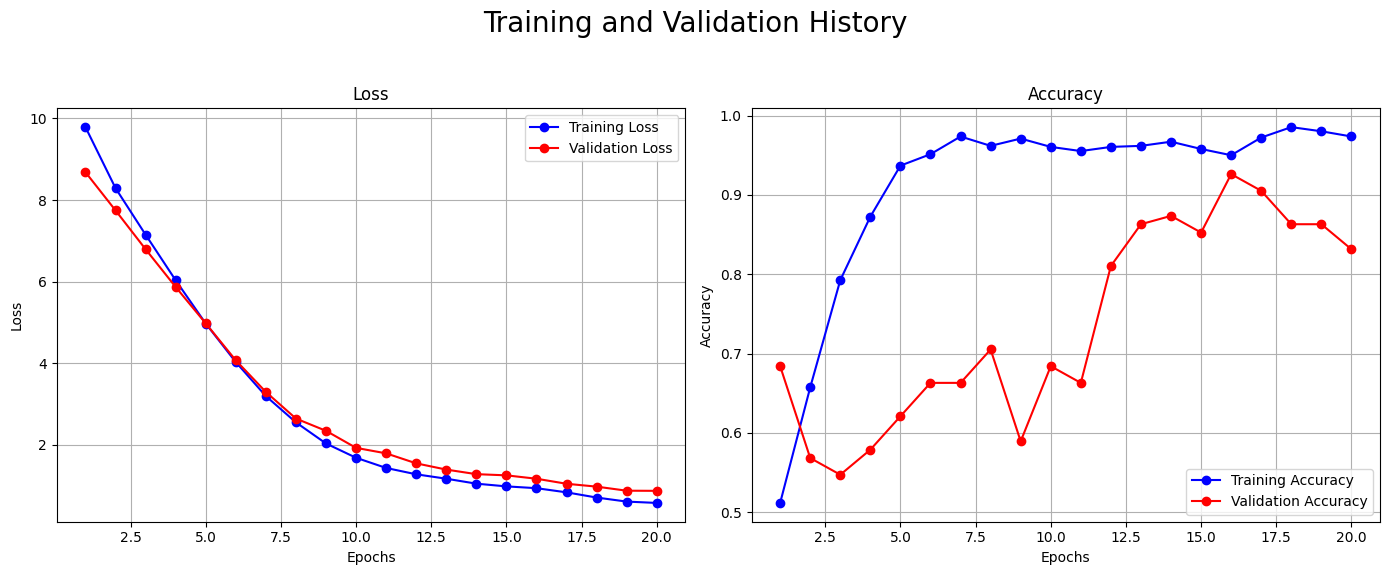

In [309]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # For a standard MLP with a single output and single loss/accuracy
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    train_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])

    epochs = range(1, len(train_loss) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Training and Validation History', fontsize=20)

    # Plot Loss
    axs[0].plot(epochs, train_loss, 'bo-', label='Training Loss')
    axs[0].plot(epochs, val_loss, 'ro-', label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    if train_acc and val_acc:
        axs[1].plot(epochs, train_acc, 'bo-', label='Training Accuracy')
        axs[1].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
        axs[1].set_title('Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_training_history(history)



---



# 6 - MODEL EVALUATION

This section is dedicated to the final evaluation of the best-performing model, identified through the hyperparameter optimization process.

The evaluation is conducted on the **unseen test set** to provide an unbiased estimate of the model's generalization capabilities. The process follows the plan outlined in the exam:
1.  Evaluate the classification task.
2.  Visualize the results to gain deeper insights (e.g., Confusion Matrix and performance plots).

In [315]:

# Predict on test set
test_pred = best_model.predict(
    {
        'country_input': test_country_tensor,
        'city_input': test_city_tensor,
        'ad_input': test_ad_seqs,
        'query_input': test_hot_tensor,
        'numeric_input': test_nums_tensor
    },
    verbose=0
)

### 6.3 Task-Specific Quantitative Evaluation
Following the visual analysis, we now compute the specific metrics for each task as planned in the exam.


Regression Task
Mean Squared Error on Test Set: 1.7814
Accuracy within +/- 1.5 score points: 77.21%

Classification Task
Accuracy on Test Set: 0.8911
F1 Score on Test Set: 0.8948


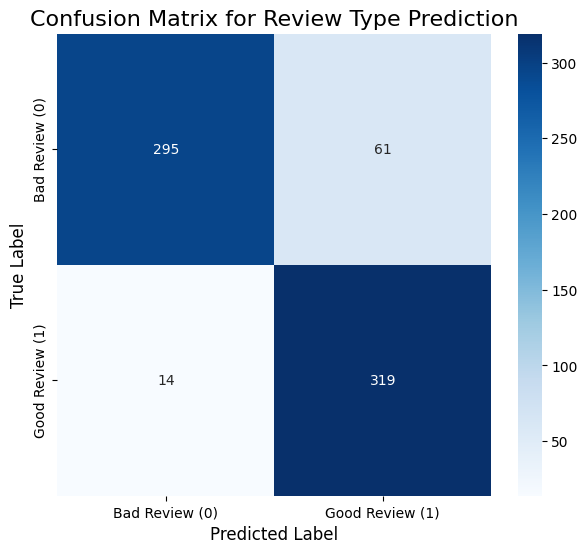

In [ ]:
print("\nRegression Task")
test_mse = mean_squared_error(test_df['Review_Score'], test_pred_score_clipped)
print(f"Mean Squared Error on Test Set: {test_mse:.4f}")

def evaluate_score_on_scale(true_scores, predicted_scores, tolerance=1.5):
    correct_within_tolerance = np.sum(np.abs(true_scores - predicted_scores) <= tolerance)
    accuracy_within_tolerance = correct_within_tolerance / len(true_scores)
    print(f"Accuracy within +/- {tolerance} score points: {accuracy_within_tolerance:.2%}")

evaluate_score_on_scale(test_df['Review_Score'].values, test_pred_score_clipped)

print("\nClassification Task")
test_accuracy = accuracy_score(test_df['Review_Type'], test_pred_label)
test_f1 = f1_score(test_df['Review_Type'], test_pred_label)

print(f"Accuracy on Test Set: {test_accuracy:.4f}")
print(f"F1 Score on Test Set: {test_f1:.4f}")

cm = confusion_matrix(test_df['Review_Type'], test_pred_label)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Review (0)', 'Good Review (1)'],
            yticklabels=['Bad Review (0)', 'Good Review (1)'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Review Type Prediction', fontsize=16)
plt.show()

# 6 - MODEL INTERPRETATION (LIME )